In [2]:
!wget https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/quantization_content.zip && unzip -q quantization_content.zip && rm quantization_content.zip

--2023-12-06 09:43:11--  https://optimization-thinkautonomous.s3.eu-west-3.amazonaws.com/quantization_content.zip
optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com) 해석 중... 16.12.20.26, 16.12.20.34
다음으로 연결 중: optimization-thinkautonomous.s3.eu-west-3.amazonaws.com (optimization-thinkautonomous.s3.eu-west-3.amazonaws.com)|16.12.20.26|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 544242167 (519M) [application/zip]
저장 위치: `quantization_content.zip.1'

quantization_conten 100%[===================>] 519.03M   450KB/s    / 20m 37s  

2023-12-06 10:03:50 (429 KB/s) - `quantization_content.zip.1' 저장함 [544242167/544242167]

[quantization_content.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zi

In [3]:
# Basic imports
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# DL imports 
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import warnings
warnings.filterwarnings("ignore") 

In [4]:
from scripts.helper import cityScapeDataset

In [5]:
NUM_CLASSES = 19
IGNORE_INDEX = 255

# Convert to torch tensor and normalize images using Imagenet values
tf = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.485, 0.56, 0.406), std=(0.229, 0.224, 0.225))
                ])

TEST_BATCH_SIZE  = 8

# Creating Test set and Test Dataloaders
test_set = cityScapeDataset(rootDir= 'semSeg_256_512', folder='val', tf = tf)
test_set = torch.utils.data.Subset(test_set, indices=np.arange(40))
test_dataloader  = DataLoader(test_set, batch_size=TEST_BATCH_SIZE)

In [6]:
rgb_image, label_image = test_set[0]
print(f"There are {len(test_set)} test Images")
print(f"Input shape = {rgb_image.numpy().shape}, output label shape = {label_image.numpy().shape}")

There are 40 test Images
Input shape = (3, 256, 512), output label shape = (256, 512)


## 1. Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


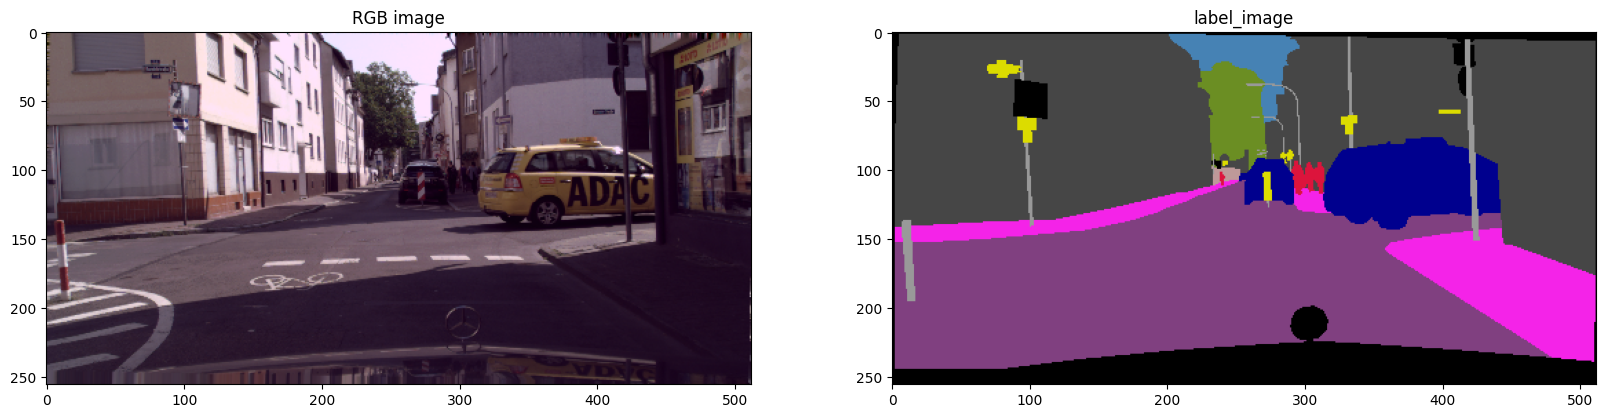

In [8]:
from scripts.helper import inverse_transform, decodeTarget        
        
source_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy() # From Normalized to RGB
colormapped_label_image = decodeTarget(label_image).astype('uint8')

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20, 40))
ax1.imshow(source_image)
ax1.set_title("RGB image")
ax2.imshow(colormapped_label_image)
ax2.set_title("label_image")
plt.show()

# 2. Model

In [9]:
from scripts.helper import meanIoU

In [10]:
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

# import model class
from scripts.models.segmentation import deeplabv3_resnet50

## ⭐ FP32 MODEL
# load pretrained model and transfer to CPU, set to inference mode
fp32_model = deeplabv3_resnet50(pretrained=False, num_classes=NUM_CLASSES)
fp32_model.load_state_dict(torch.load('weightFiles/deeplabv3_r50.pt', map_location=cpu_device))
fp32_model.eval();

# evaluate performance on Test set
from scripts.helper import evaluteOnTestData

fp32_model_metric = evaluteOnTestData(fp32_model, None, gpu_device, test_dataloader, meanIoU, 'meanIoU', 'fp32_model_deepLabv3')
print(f"\nfp32_model has {round(fp32_model_metric,3)} IoU metric on test data")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jovyan/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

100%|██████████| 5/5 [00:06<00:00,  1.31s/it]


fp32_model has 0.559 IoU metric on test data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


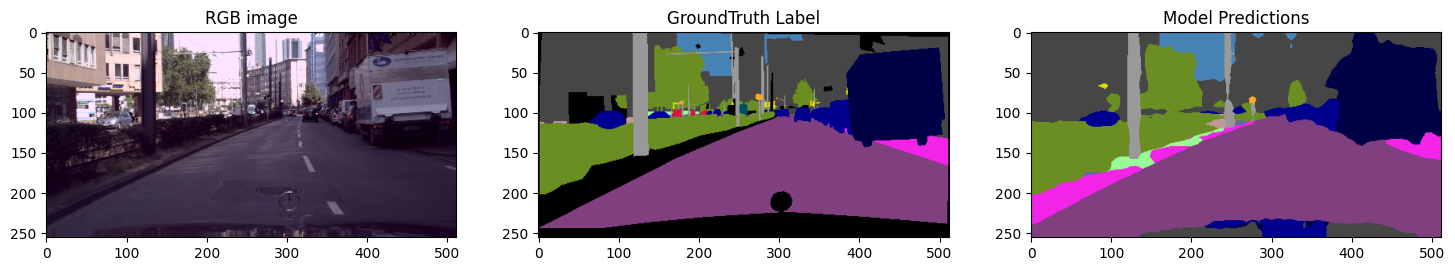

In [11]:
from scripts.helper import visualizePredictions
visualizePredictions(fp32_model, test_set, cpu_device, 1)

In [12]:
## Save scripted version of the fp32 model, and load it for benchmarking
torch.jit.save(torch.jit.script(fp32_model), 'weightFiles/fp32_jit_deeplabv3.pt')
fp32_jit_model = torch.jit.load('weightFiles/fp32_jit_deeplabv3.pt', map_location = cpu_device)

# 3. Static Quantization of Pre-trained Model

Here's how it happens, starting with an FP32 Model:

1. Module Fusion — Conv+BatchNorm+ReLU

2. Formula Definition

3. Select a Deployment Environment

4. Calibrate on the Dataset

5. Convert to Int8


In [13]:
from copy import deepcopy
model_to_quantize = deepcopy(fp32_model)
model_to_quantize.eval();
model_to_quantize.to(cpu_device);

In [14]:
# print(fp32_model)

### 1. Module Fusion - Conv + BatchNrom + ReLU

In [15]:
modules_to_fuse = [
        ['backbone.conv1', 'backbone.bn1', 'backbone.relu'],

        ['backbone.layer1.0.conv1', 'backbone.layer1.0.bn1', 'backbone.layer1.0.relu1'],
        ['backbone.layer1.0.conv2', 'backbone.layer1.0.bn2', 'backbone.layer1.0.relu2'],
        ['backbone.layer1.0.conv3', 'backbone.layer1.0.bn3'],
        ['backbone.layer1.0.downsample.0', 'backbone.layer1.0.downsample.1'],

        ['backbone.layer1.1.conv1', 'backbone.layer1.1.bn1', 'backbone.layer1.1.relu1'],
        ['backbone.layer1.1.conv2', 'backbone.layer1.1.bn2', 'backbone.layer1.1.relu2'],
        ['backbone.layer1.1.conv3', 'backbone.layer1.1.bn3'],

        ['backbone.layer1.2.conv1', 'backbone.layer1.2.bn1', 'backbone.layer1.2.relu1'],
        ['backbone.layer1.2.conv2', 'backbone.layer1.2.bn2', 'backbone.layer1.2.relu2'],
        ['backbone.layer1.2.conv3', 'backbone.layer1.2.bn3'],

        ['backbone.layer2.0.conv1', 'backbone.layer2.0.bn1', 'backbone.layer2.0.relu1'],
        ['backbone.layer2.0.conv2', 'backbone.layer2.0.bn2', 'backbone.layer2.0.relu2'],
        ['backbone.layer2.0.conv3', 'backbone.layer2.0.bn3'],
        ['backbone.layer2.0.downsample.0', 'backbone.layer2.0.downsample.1'],

        ['backbone.layer2.1.conv1', 'backbone.layer2.1.bn1', 'backbone.layer2.1.relu1'],
        ['backbone.layer2.1.conv2', 'backbone.layer2.1.bn2', 'backbone.layer2.1.relu2'],
        ['backbone.layer2.1.conv3', 'backbone.layer2.1.bn3'],

        ['backbone.layer2.2.conv1', 'backbone.layer2.2.bn1', 'backbone.layer2.2.relu1'],
        ['backbone.layer2.2.conv2', 'backbone.layer2.2.bn2', 'backbone.layer2.2.relu2'],
        ['backbone.layer2.2.conv3', 'backbone.layer2.2.bn3'],

        ['backbone.layer2.3.conv1', 'backbone.layer2.3.bn1', 'backbone.layer2.3.relu1'],
        ['backbone.layer2.3.conv2', 'backbone.layer2.3.bn2', 'backbone.layer2.3.relu2'],
        ['backbone.layer2.3.conv3', 'backbone.layer2.3.bn3'],

        ['backbone.layer3.0.conv1', 'backbone.layer3.0.bn1', 'backbone.layer3.0.relu1'],
        ['backbone.layer3.0.conv2', 'backbone.layer3.0.bn2', 'backbone.layer3.0.relu2'],
        ['backbone.layer3.0.conv3', 'backbone.layer3.0.bn3'],
        ['backbone.layer3.0.downsample.0', 'backbone.layer3.0.downsample.1'],

        ['backbone.layer3.1.conv1', 'backbone.layer3.1.bn1', 'backbone.layer3.1.relu1'],
        ['backbone.layer3.1.conv2', 'backbone.layer3.1.bn2', 'backbone.layer3.1.relu2'],
        ['backbone.layer3.1.conv3', 'backbone.layer3.1.bn3'],

        ['backbone.layer3.2.conv1', 'backbone.layer3.2.bn1', 'backbone.layer3.2.relu1'],
        ['backbone.layer3.2.conv2', 'backbone.layer3.2.bn2', 'backbone.layer3.2.relu2'],
        ['backbone.layer3.2.conv3', 'backbone.layer3.2.bn3'],

        ['backbone.layer3.3.conv1', 'backbone.layer3.3.bn1', 'backbone.layer3.3.relu1'],
        ['backbone.layer3.3.conv2', 'backbone.layer3.3.bn2', 'backbone.layer3.3.relu2'],
        ['backbone.layer3.3.conv3', 'backbone.layer3.3.bn3'],

        ['backbone.layer3.4.conv1', 'backbone.layer3.4.bn1', 'backbone.layer3.4.relu1'],
        ['backbone.layer3.4.conv2', 'backbone.layer3.4.bn2', 'backbone.layer3.4.relu2'],
        ['backbone.layer3.4.conv3', 'backbone.layer3.4.bn3'],

        ['backbone.layer3.5.conv1', 'backbone.layer3.5.bn1', 'backbone.layer3.5.relu1'],
        ['backbone.layer3.5.conv2', 'backbone.layer3.5.bn2', 'backbone.layer3.5.relu2'],
        ['backbone.layer3.5.conv3', 'backbone.layer3.5.bn3'],

        ['backbone.layer4.0.conv1', 'backbone.layer4.0.bn1', 'backbone.layer4.0.relu1'],
        ['backbone.layer4.0.conv2', 'backbone.layer4.0.bn2', 'backbone.layer4.0.relu2'],
        ['backbone.layer4.0.conv3', 'backbone.layer4.0.bn3'],
        ['backbone.layer4.0.downsample.0', 'backbone.layer4.0.downsample.1'],

        ['backbone.layer4.1.conv1', 'backbone.layer4.1.bn1', 'backbone.layer4.1.relu1'],
        ['backbone.layer4.1.conv2', 'backbone.layer4.1.bn2', 'backbone.layer4.1.relu2'],
        ['backbone.layer4.1.conv3', 'backbone.layer4.1.bn3'],

        ['backbone.layer4.2.conv1', 'backbone.layer4.2.bn1', 'backbone.layer4.2.relu1'],
        ['backbone.layer4.2.conv2', 'backbone.layer4.2.bn2', 'backbone.layer4.2.relu2'],
        ['backbone.layer4.2.conv3', 'backbone.layer4.2.bn3'],

        ['classifier.0.convs.0.0', 'classifier.0.convs.0.1', 'classifier.0.convs.0.2'],
        ['classifier.0.convs.1.0', 'classifier.0.convs.1.1', 'classifier.0.convs.1.2'],
        ['classifier.0.convs.2.0', 'classifier.0.convs.2.1', 'classifier.0.convs.2.2'],
        ['classifier.0.convs.3.0', 'classifier.0.convs.3.1', 'classifier.0.convs.3.2'],
        ['classifier.0.convs.4.1', 'classifier.0.convs.4.2', 'classifier.0.convs.4.3'],

        ['classifier.0.project.0', 'classifier.0.project.1', 'classifier.0.project.2'],
        ['classifier.1', 'classifier.2', 'classifier.3']
    ]

In [16]:
## ⭐ FUSED MODEL
fused_model = torch.quantization.fuse_modules(model_to_quantize, modules_to_fuse, inplace=True)
# print(fused_model)

*Effect*

- conv2d modules are converted to ConvRelu2d

- BatchNorm2d and relu modules are converted to Identity

### 2. Formula Definition

- Here, we'll define a nn.Module class which will take the floating point model and create stubs for input, output using torch APIs.

- QuantStub map the floating point input data to integer

- DeQuantStub map the integer model predictions to floating point representation

In [19]:
class quantStubModel(nn.Module):
    def __init__(self, model_fp32):
        super(quantStubModel, self).__init__()
        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = torch.quantization.QuantStub()
        
        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        self.dequant = torch.quantization.DeQuantStub()
        
        self.model_fp32 = model_fp32

    def forward(self, x):
        x = self.quant(x)
        x = self.model_fp32(x)
        x = self.dequant(x)
        return x

# ⭐ QUANT STUBBED MODEL
# creating nn.Module with stubs for inputs and outputs
quant_stubbed_model = quantStubModel(model_fp32=fused_model)

### 3. Select a Deployment Environment 

3.1. The most important parameter is the **backend selection**.

    - fbgemm: a backend for CPU & Colab Envs
    
    - qnnpack: a backend for ARM architectures

In [20]:
use_fbgemm = True

if use_fbgemm == True:
  quantization_config = torch.quantization.get_default_qconfig('fbgemm')
  torch.backends.quantized.engine = 'fbgemm'

else:
  quantization_config = torch.quantization.default_qconfig
  torch.backends.quantized.engine = 'qnnpack'

3.2. Select an Observer to "calibrate"

- Pytorch uses an `Observer` to calculate parameters required to approximate a module

- Observer type and its properties can be set using configuration parameters

- When 'quantization.prepare()' function is called, observers are inserted into every module to be quantized.

In [22]:
quant_stubbed_model.qconfig = quantization_config    
torch.quantization.prepare(quant_stubbed_model, inplace=True)

quantStubModel(
  (quant): QuantStub(
    (activation_post_process): HistogramObserver()
  )
  (dequant): DeQuantStub()
  (model_fp32): DeepLabV3(
    (backbone): IntermediateLayerGetter(
      (conv1): ConvReLU2d(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): ReLU(inplace=True)
        (activation_post_process): HistogramObserver()
      )
      (bn1): Identity()
      (relu): Identity()
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): ConvReLU2d(
            (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (1): ReLU(inplace=True)
            (activation_post_process): HistogramObserver()
          )
          (bn1): Identity()
          (relu1): Identity()
          (conv2): ConvReLU2d(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
     

### 4. Calibrate on the Dataset


In [23]:
quantSet = torch.utils.data.Subset(test_set, indices=np.arange(24))
quantDataloader = DataLoader(quantSet, batch_size=TEST_BATCH_SIZE)

with torch.no_grad():
    for inputs, labels in tqdm(quantDataloader):
        inputs, labels = inputs.to(cpu_device), labels.to(cpu_device)
        _ = quant_stubbed_model(inputs)

100%|██████████| 3/3 [00:36<00:00, 12.12s/it]


위 코드를 사용하여 calibration을 수행하는 과정을 단계별로 설명하자면, 

1. quantSet 데이터셋에서 24개의 데이터 샘플을 선택합니다.

2. quantDataloader를 사용하여 quantSet 데이터셋을 로더에 넣습니다.

3. quant_stubbed_model 함수를 사용하여 모델의 입력값 분포를 분석합니다.

4. 분석 결과를 바탕으로 양자화 범위를 설정합니다.

### 5. Convert to Int8 (and save)

In [24]:
# ⭐⭐ Quantized Model
quantized_model = torch.quantization.convert(quant_stubbed_model, inplace=True)

In [25]:
torch.jit.save(torch.jit.script(quantized_model), 'weightFiles/int8_jit_deepLabv3.pt')

### 6. Results

100%|██████████| 5/5 [00:14<00:00,  2.83s/it]



int8_model has 0.552 IoU metric on test data


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


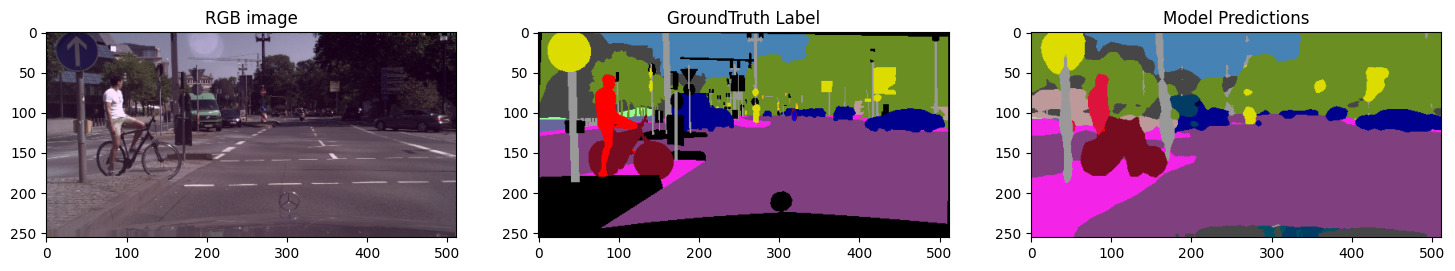

In [26]:
# Load quantized model
int8_jit_model = torch.jit.load('weightFiles/int8_jit_deepLabv3.pt', map_location=cpu_device)

# Evaluate performance on Test set
int8_model_metric = evaluteOnTestData(int8_jit_model, None, cpu_device, test_dataloader, meanIoU, 
                                    'meanIoU', 'int8_model_deepLabv3')
print(f"\nint8_model has {round(int8_model_metric,3)} IoU metric on test data")

# Visualize output predictions
visualizePredictions(int8_jit_model, test_set, cpu_device, 1)

In [27]:
from scripts.modelMetrics import modelMetrics

torch.set_num_threads(1)

_ = modelMetrics(fp32_jit_model, modelName= 'fp32_jit_deeplabv3', 
             input=torch.rand(1,3,256,256), device=cpu_device, verbose=True)

_ = modelMetrics(int8_jit_model, modelName= 'quantized_jit_deeplabv3', 
             input=torch.rand(1,3,256,256), device=cpu_device, verbose=True)

-------------
 Metrics of fp32_jit_deeplabv3 
-------------
Device = cpu
NA MMACs, NA MFLOPs and NA M parameters
Model FileSize = 158.974635 MB
Single batch inference Time of model = 2700.4175901412964 milliseconds
-------------
 Metrics of quantized_jit_deeplabv3 
-------------
Device = cpu
NA MMACs, NA MFLOPs and NA M parameters
Model FileSize = 40.256307 MB
Single batch inference Time of model = 545.9506750106812 milliseconds
